In [1]:
!pip3 install tensorflow-macos tensorflow-metal opencv-python matplotlib pandas python-mnist numpy Pillow seaborn scikit-learn

In [2]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import glob
from PIL import Image
from tensorflow.keras import optimizers
from mnist import MNIST
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [3]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("Using gpu: ", gpus)
else:
    print("no gpu found using cpu")

Using gpu:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Dataset

In [4]:
mndata = MNIST('archive')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

In [5]:
train_images = np.array(train_images, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.int32)
test_images = np.array(test_images, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.int32)

train_images=train_images.reshape(-1,28,28,1)
test_images=test_images.reshape(-1,28,28,1)

train_images /= 255.0
test_images /= 255.0

## Data Augmentation

In [6]:
rotation_layer = layers.RandomRotation(
    factor=0.05,
    fill_mode="constant")
translation_layer = layers.RandomTranslation(
    0.1,0.1,
    fill_mode='constant',
    interpolation='bilinear',
)
zoom_layer = layers.RandomZoom(
    (-0.15,0.15),
    fill_mode='constant',
    interpolation='bilinear'
)

def augment_image(image,label):
    #rotation
    image = rotation_layer(image, training=True)
    #translation/shifting
    image = translation_layer(image, training=True)
    #zoom
    image = zoom_layer(image, training=True)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

2025-09-14 13:28:55.440364: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-14 13:28:55.440384: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-14 13:28:55.440387: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-14 13:28:55.440400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-14 13:28:55.440409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Dataset for tensorflow

In [7]:
BATCH_SIZE = 32

def make_dataset(image, label, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((image,label))
    if training:
        dataset=dataset.map(augment_image,num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset=dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

train_ds = make_dataset(train_images, train_labels, training=True)
test_ds = make_dataset(test_images, test_labels, training=False)

## Building the model

In [8]:
def create_model():
    model=models.Sequential([
        # first convolution block
        # 32 filters
        layers.Conv2D(32,(3,3),activation='relu', input_shape=(28,28,1)),
        # reduce dimension by half
        layers.MaxPooling2D((2,2)),

        # second convolution block
        # 64 filters
        layers.Conv2D(64,(3,3),activation='relu'),
        # reduce dimension by half
        layers.MaxPooling2D((2,2)),

        # third convolution block
        # 128 filters
        layers.Conv2D(128,(3,3),activation='relu'),
        # reduce dimension by half
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        #dense layer
        layers.Dense(128,activation='relu'),
        #disable 50% neurons
        layers.Dropout(0.5),

        layers.Dense(10, activation='softmax'),
    ])

    return model

In [9]:
model = create_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model summary

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

## Adding callback

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "model.keras",
    monitor="val_loss",
    save_best_only=True
)

## Train

In [13]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50


2025-09-14 13:28:56.100714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8223 - loss: 0.5500 - val_accuracy: 0.9654 - val_loss: 0.1135
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.9312 - loss: 0.2259 - val_accuracy: 0.9765 - val_loss: 0.0784
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9467 - loss: 0.1770 - val_accuracy: 0.9752 - val_loss: 0.0801
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.9526 - loss: 0.1601 - val_accuracy: 0.9789 - val_loss: 0.0757
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.9574 - loss: 0.1449 - val_accuracy: 0.9839 - val_loss: 0.0590
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.9608 - loss: 0.1352 - val_accuracy: 0.9841 - val_loss: 0.0635
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - accuracy: 0.9621 - loss: 0.1292 - val_accuracy: 0.9866 - val_loss: 0.0480
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9650 - loss: 0.11

## Save the model

In [14]:
model.save("model.keras")

## Plot Shit

In [15]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_model_performance(model, test_ds):
    """
    Plot confusion matrix and classification report
    """
    # Get predictions
    y_pred = []
    y_true = []
    
    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # Plot confusion matrix
    
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Calculate and print accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Print classification report
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))

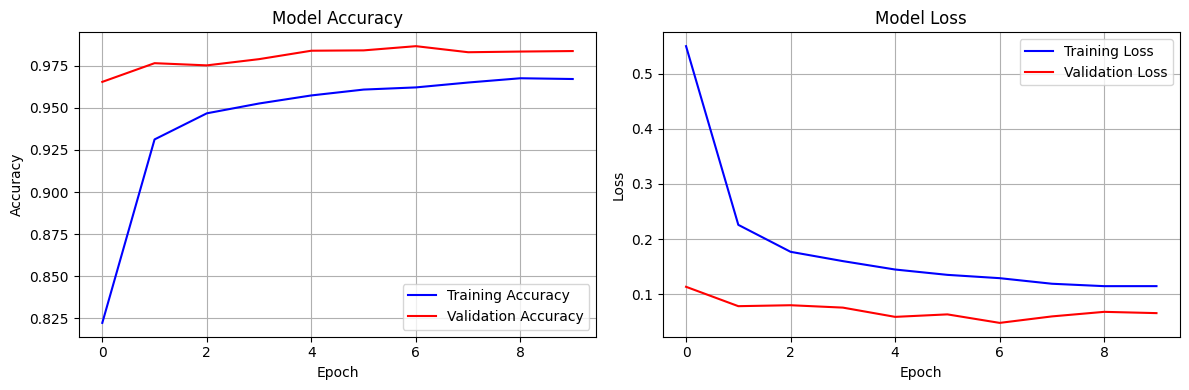

In [16]:
plot_training_history(history)

2025-09-14 13:35:28.530181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


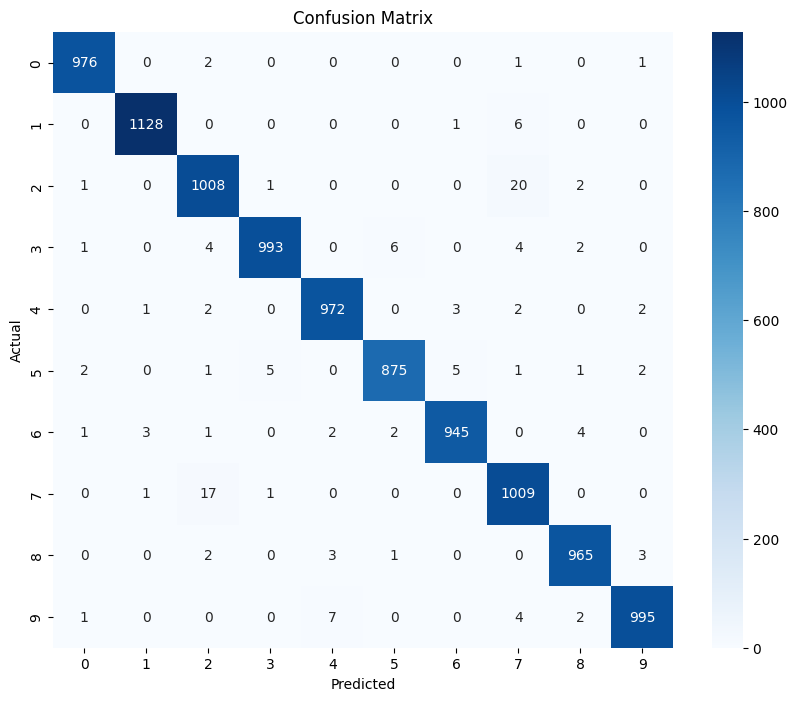

Test Accuracy: 0.9866

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.96      0.98      0.97      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [17]:
plot_model_performance(model, test_ds)

## Test Shit

In [18]:
def preprocess_image(image_path):
    """
    Preprocess a single image for prediction
    """
    try:
        # Load image
        img = Image.open(image_path)
        
        # Convert to grayscale if needed
        if img.mode != 'L':
            img = img.convert('L')
        
        # Resize to 28x28
        img = img.resize((28, 28))
        
        # Convert to numpy array
        img_array = np.array(img, dtype=np.float32)
        
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        
        # Reshape to (1, 28, 28, 1) for model input
        img_array = img_array.reshape(1, 28, 28, 1)
        
        return img_array
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def predict_images_from_folder(model, folder_path, num_images=6):
    """
    Predict digit images from a folder and display results
    """
    # Get all image files from folder
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_files = []
    
    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, extension)))
    
    if not image_files:
        print(f"No image files found in {folder_path}")
        return
    
    # Limit to num_images
    image_files = image_files[:num_images]
    
    # Set up the plot
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for i, image_path in enumerate(image_files):
        if i >= num_images:
            break
            
        # Preprocess image
        processed_img = preprocess_image(image_path)
        
        if processed_img is not None:
            # Make prediction
            prediction = model.predict(processed_img, verbose=0)
            predicted_digit = np.argmax(prediction[0])
            confidence = np.max(prediction[0])
            
            # Load original image for display
            original_img = Image.open(image_path)
            if original_img.mode != 'L':
                original_img = original_img.convert('L')
            
            # Plot the image
            axes[i].imshow(original_img, cmap='gray')
            axes[i].set_title(f'Predicted: {predicted_digit}\nConfidence: {confidence:.3f}')
            axes[i].axis('off')
            
            print(f"Image: {os.path.basename(image_path)}")
            print(f"Predicted digit: {predicted_digit}")
            print(f"Confidence: {confidence:.3f}")
            print("-" * 30)
        else:
            axes[i].text(0.5, 0.5, 'Error loading\nimage', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def predict_test_samples(model, test_images, test_labels, num_samples=6):
    """
    Predict some test samples and show results
    """
    # Get random samples
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get the image and true label
        img = test_images[idx]
        true_label = test_labels[idx]
        
        # Make prediction
        prediction = model.predict(img.reshape(1, 28, 28, 1), verbose=0)
        predicted_label = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        # Plot
        axes[i].imshow(img.reshape(28, 28), cmap='gray')
        color = 'green' if predicted_label == true_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {predicted_label}\nConf: {confidence:.3f}', 
                         color=color)
        axes[i].axis('off')
    
    plt.suptitle('Test Sample Predictions (Green=Correct, Red=Wrong)')
    plt.tight_layout()
    plt.show()

Image: three.jpg
Predicted digit: 3
Confidence: 0.895
------------------------------
Image: two.jpg
Predicted digit: 2
Confidence: 0.401
------------------------------
Image: six.jpg
Predicted digit: 6
Confidence: 0.960
------------------------------
Image: four.jpg
Predicted digit: 1
Confidence: 0.292
------------------------------
Image: zero.jpg
Predicted digit: 0
Confidence: 0.548
------------------------------
Image: eight.jpg
Predicted digit: 8
Confidence: 0.991
------------------------------


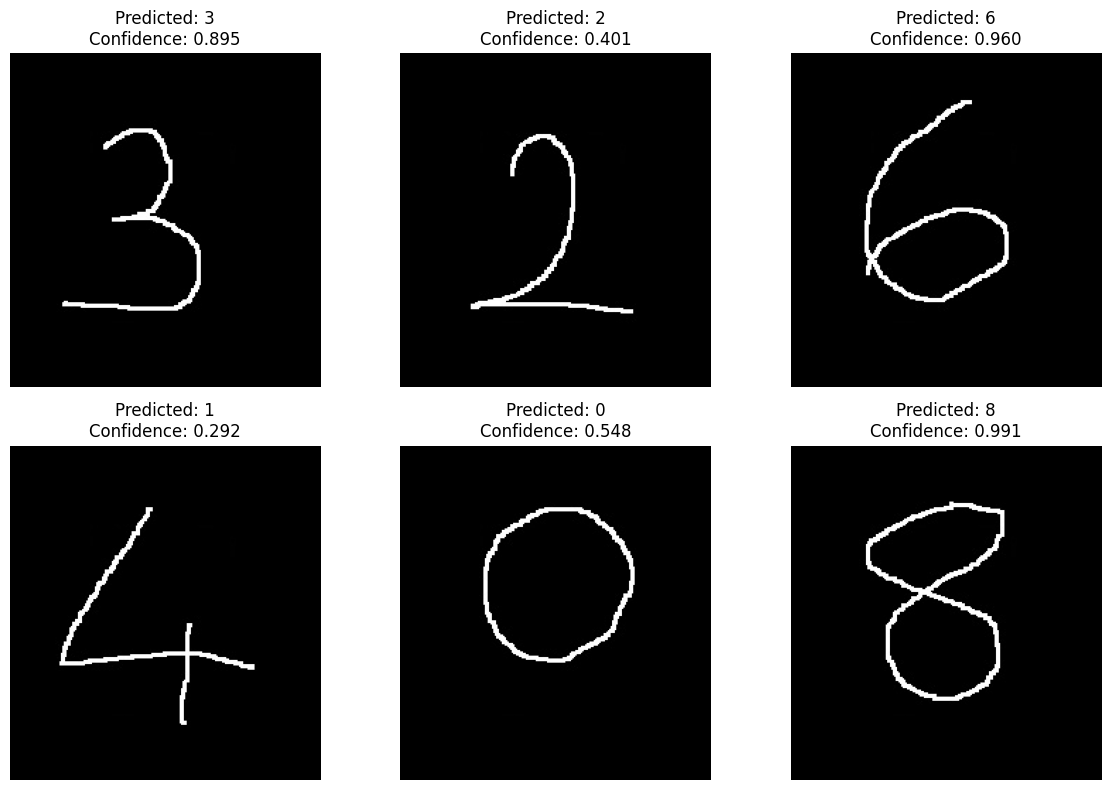

In [19]:
predict_images_from_folder(model, "test")